# Phần 1: Vẽ biểu đồ Dendrogram (Cây phân cấp)
Khác với K-means phải đoán trước số cụm, phân cụm đa cấp cho phép ta nhìn thấy toàn bộ cấu trúc dữ liệu từ dưới lên trên.

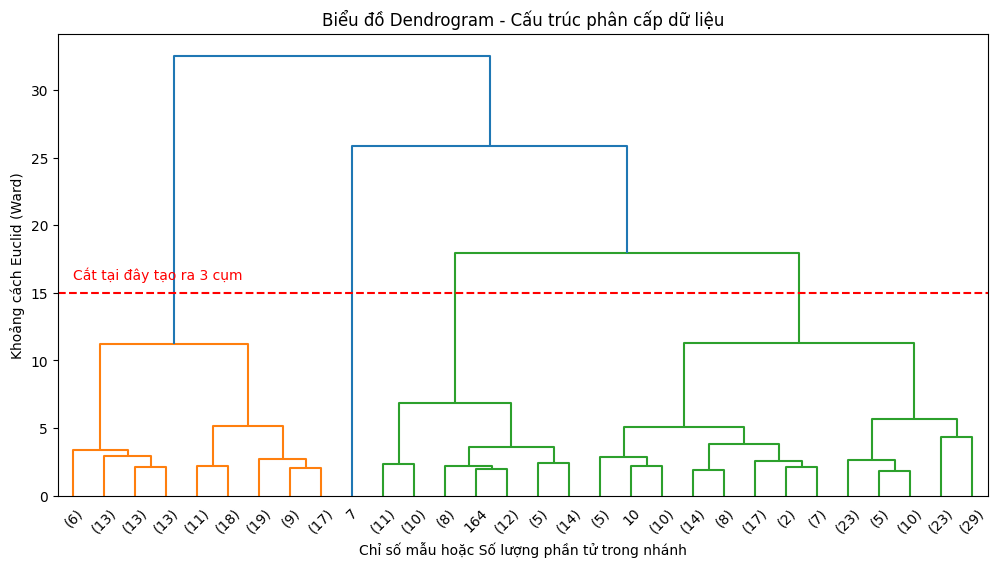

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

# 1. Chuẩn bị dữ liệu (như bài trước)
df = pd.read_csv('penguins.csv')
df_clean = df.dropna().copy()
X = df_clean[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']]

# Chuẩn hóa (Rất quan trọng)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Tính toán Linkage Matrix
# Đây là bước tính khoảng cách giữa tất cả các điểm để biết điểm nào gần điểm nào nhất
# phương pháp 'ward' giúp tối ưu hóa phương sai (tạo ra các cụm tròn đều)
linked = linkage(X_scaled, method='ward')

# 3. Vẽ Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(
    linked,
    orientation='top',
    truncate_mode='lastp',  # Chỉ hiển thị 30 nhánh cuối cùng cho gọn
    p=30,
    show_leaf_counts=True,
    leaf_rotation=45.,
    leaf_font_size=10.,
)
plt.title('Biểu đồ Dendrogram - Cấu trúc phân cấp dữ liệu')
plt.xlabel('Chỉ số mẫu hoặc Số lượng phần tử trong nhánh')
plt.ylabel('Khoảng cách Euclid (Ward)')

# Vẽ đường cắt ngang (Threshold) để chọn số cụm
# Nhìn vào biểu đồ, khoảng cách nhảy vọt lớn nhất là khoảng y=15 đến y=30
plt.axhline(y=15, color='r', linestyle='--') 
plt.text(x=5, y=16, s='Cắt tại đây tạo ra 3 cụm', color='r')

plt.show()

Phân tích biểu đồ Dendrogram:

Trục tung (Y): Thể hiện khoảng cách. Nhánh dọc càng dài nghĩa là khoảng cách giữa hai nhóm được gộp vào nhau càng lớn (chúng càng khác biệt).

Quyết định số cụm: Chúng ta tìm những đường dọc dài nhất mà không bị cắt ngang bởi các đường ngang khác. Trong hình, nếu ta kẻ một đường ngang ở mức y=15 (đường màu đỏ), nó sẽ cắt qua 3 nhánh dọc lớn. Điều này xác nhận lại rằng chọn K=3 là hợp lý nhất cho dữ liệu này.

# Phần 2: Xây dựng Mô hình & Trực quan hóa

Bây giờ ta dùng AgglomerativeClustering từ thư viện sklearn để thực hiện việc gom nhóm chính thức với $K=3$.

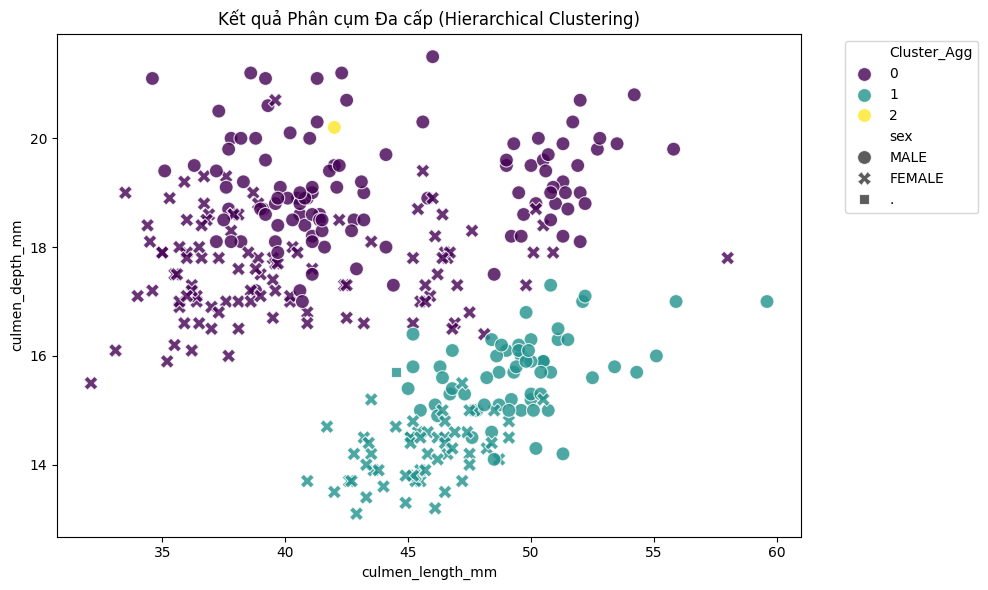

Số lượng mẫu trong từng cụm:
Cluster_Agg
0    215
1    119
2      1
Name: count, dtype: int64


In [14]:
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

# 1. Khởi tạo và chạy mô hình
# n_clusters=3: Chọn 3 cụm dựa trên Dendrogram
# linkage='ward': Phải khớp với phương pháp dùng khi vẽ Dendrogram
agg_cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')

# Gán nhãn cho dữ liệu
df_clean['Cluster_Agg'] = agg_cluster.fit_predict(X_scaled)

# 2. Vẽ biểu đồ phân tán (Scatter Plot) với Giới tính
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clean,
    x='culmen_length_mm',
    y='culmen_depth_mm',
    hue='Cluster_Agg',  # Màu theo Cụm
    style='sex',        # Hình dáng theo Giới tính
    palette='viridis',
    s=100,
    alpha=0.8
)
plt.title('Kết quả Phân cụm Đa cấp (Hierarchical Clustering)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# In thống kê số lượng
print("Số lượng mẫu trong từng cụm:")
print(df_clean['Cluster_Agg'].value_counts())

Phân tích kết quả:

Kết quả phân chia của mô hình Đa cấp (Hierarchical) gần như tương đồng hoàn toàn với K-means.

Cụm 0 (Màu tím): 215 mẫu.

Cụm 1 (Màu xanh): 119 mẫu.

Cụm 2 (Màu vàng): 1 mẫu (Vẫn phát hiện ra điểm ngoại lai này).

Nhận xét: Điều này cho thấy cấu trúc dữ liệu chim cánh cụt rất rõ ràng (well-separated), nên dù dùng thuật toán nào (dựa trên tâm như K-means hay dựa trên kết nối như Hierarchical) đều cho ra kết quả giống nhau.

# Phần 3: Mở rộng biểu đồ, phân tích thêm
## Biểu đồ Clustermap (Heatmap + Dendrogram)
Biểu đồ này kết hợp giữa Heatmap (bản đồ nhiệt) và Dendrogram.

<Figure size 1000x1000 with 0 Axes>

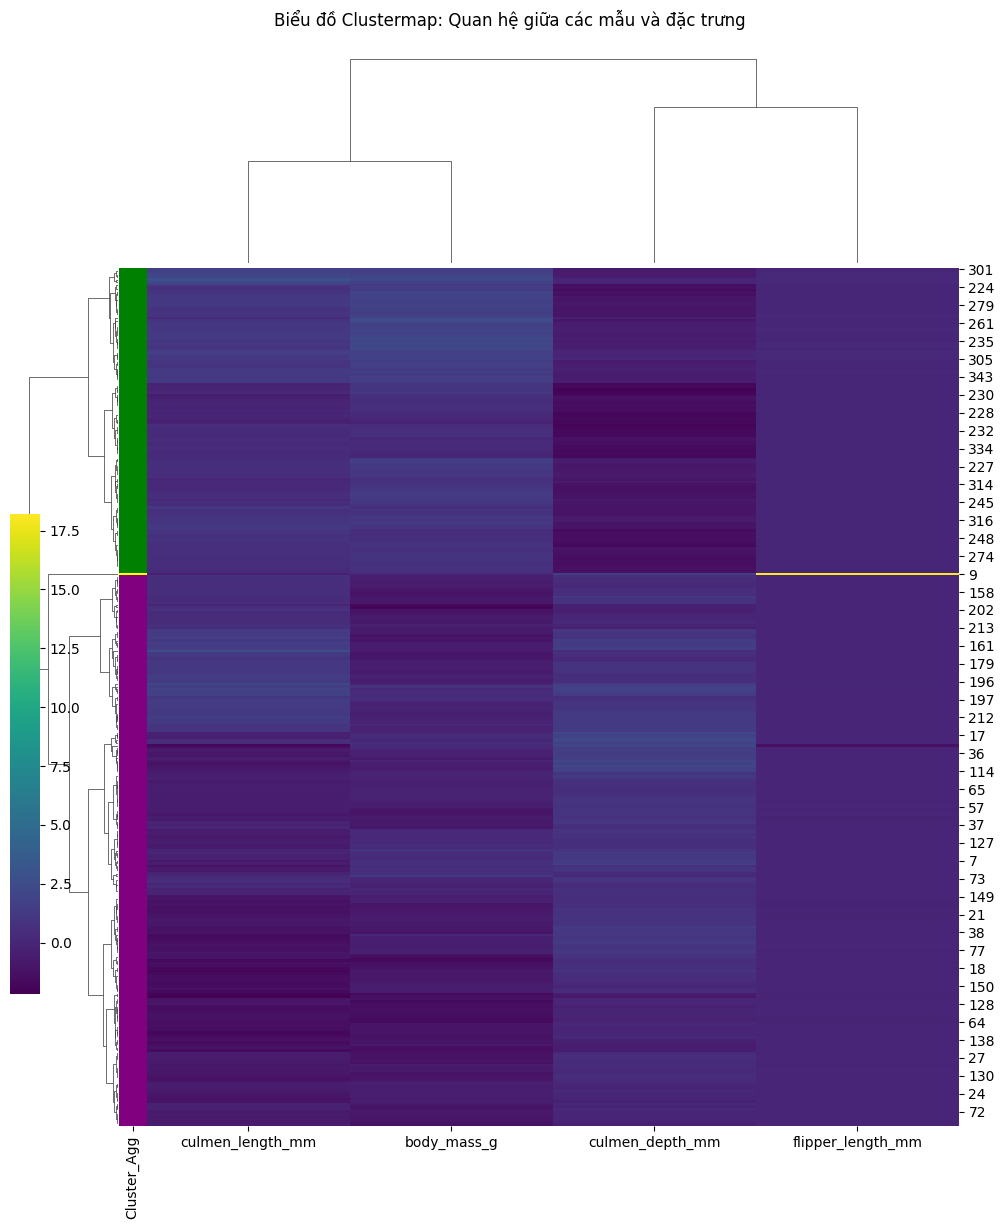

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=df_clean.index)

# Tạo bảng màu để đánh dấu các cụm
cluster_colors = df_clean['Cluster_Agg'].map({0: 'purple', 1: 'green', 2: 'yellow'})

# --- VẼ BIỂU ĐỒ ---
plt.figure(figsize=(10, 10))
g = sns.clustermap(
    X_scaled_df,
    method='ward', 
    cmap='viridis',   
    row_colors=cluster_colors, 
    figsize=(10, 12),
    dendrogram_ratio=(.1, .2), 
    cbar_pos=(0, .2, .03, .4)   
)

g.fig.suptitle('Biểu đồ Clustermap: Quan hệ giữa các mẫu và đặc trưng', y=1.02)
plt.show()

**Phân tích chi tiết Clustermap:**

Trục ngang (Phía trên): Cũng có một dendrogram nhỏ! Điều này cho thấy sự tương quan giữa các đặc trưng. Ví dụ, nếu nhánh của flipper_length và body_mass gộp lại sớm, nghĩa là 2 biến này rất giống nhau (chim cánh dài thì thường nặng).

Trục dọc (Bên trái): Là dendrogram của các mẫu dữ liệu (các chú chim). Các dòng dữ liệu được sắp xếp lại sao cho những chú chim giống nhau nằm cạnh nhau.

**Màu sắc trong ô (Heatmap):**

Màu Vàng sáng: Giá trị cao (trên trung bình).

Màu Tím đậm: Giá trị thấp (dưới trung bình).

Thanh màu dọc (Row Colors): Cho thấy các cụm (0, 1, 2) được phân tách rất gọn gàng thành các mảng lớn.

Nhìn vào mảng màu Vàng (Cụm 2, hoặc cụm tương ứng): Bạn thấy các ô ở cột body_mass_g và flipper_length_mm đều sáng rực. Điều này xác nhận trực quan rằng đây là nhóm chim "khổng lồ".

## Biểu đồ Hộp (Boxplot) - So sánh phân phối
Biểu đồ này giúp trả lời câu hỏi: "Cụ thể thì cụm 0 khác cụm 1 ở điểm nào? Mỏ dài hơn hay ngắn hơn?"

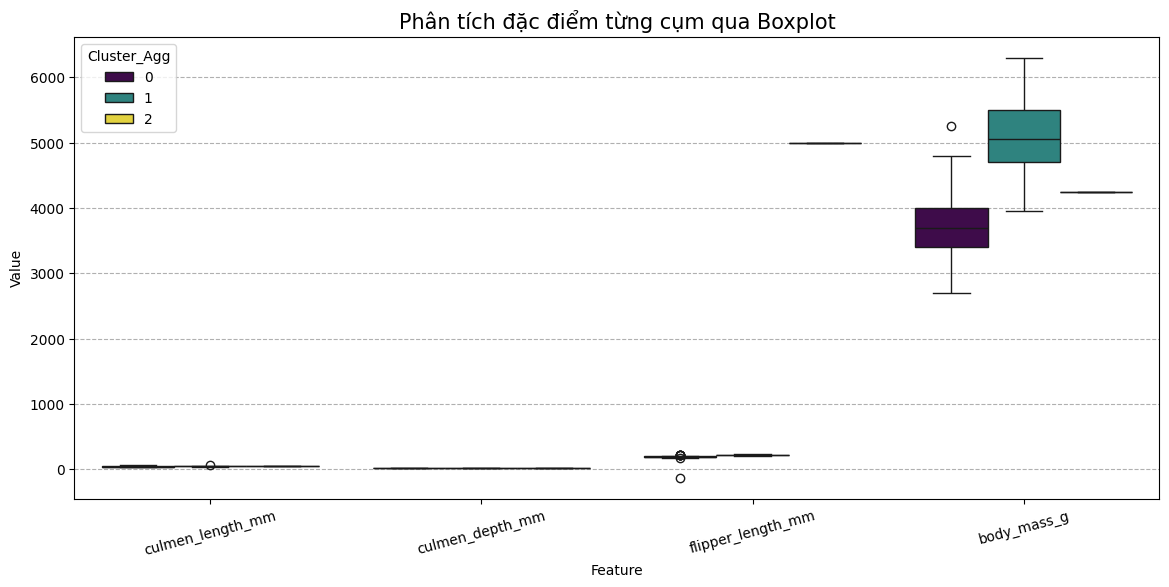

In [16]:
# Chuyển dữ liệu về dạng "long format" để vẽ seaborn dễ hơn
df_long = pd.melt(
    df_clean, 
    id_vars=['Cluster_Agg'], # Giữ cột Cluster làm mốc
    value_vars=features,     # Các cột số liệu cần vẽ
    var_name='Feature', 
    value_name='Value'
)

# Vẽ Boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df_long, 
    x='Feature', 
    y='Value', 
    hue='Cluster_Agg', # Chia nhóm theo cụm
    palette='viridis'
)
plt.title('Phân tích đặc điểm từng cụm qua Boxplot', fontsize=15)
plt.xticks(rotation=15) # Xoay tên trục cho dễ đọc
plt.grid(axis='y', linestyle='--')
plt.show()

**Phân tích chi tiết Boxplot:**

**Biểu đồ này cho ta so sánh "side-by-side" từng đặc điểm:**

**flipper_length_mm (Chiều dài cánh):**

Cụm màu Xanh lá (giả sử là Cluster 1): Hộp nằm tít trên cao (giá trị > 210mm). Đây là đặc điểm nhận dạng rõ nhất của nhóm này.

Hai cụm còn lại (Tím và Vàng) có chiều dài cánh thấp hơn và khá tương đồng nhau (hộp chồng lên nhau).

**culmen_depth_mm (Độ sâu mỏ):**

Ở đây ta thấy sự hoán đổi thú vị. Cụm màu Xanh lá (nhóm cánh dài) lại có mỏ nông nhất (hộp nằm thấp nhất).

Cụm màu Tím có mỏ sâu nhất.

**culmen_length_mm (Chiều dài mỏ):**

Cụm màu Vàng và Xanh lá có độ dài mỏ tương đương nhau (đều dài).

Cụm màu Tím có mỏ ngắn nhất rõ rệt.

**Tổng hợp đặc điểm các cụm (Profiling):**

Cụm A (Vàng): Cánh ngắn, Mỏ dài trung bình.

Cụm B (Tím): Cánh ngắn, Mỏ ngắn và sâu.

Cụm C (Xanh lá): Cánh rất dài, Nặng cân, Mỏ dài nhưng nông.